In [1]:
!pip install -q kaggle
!pip install transformers
!pip install unidecode
!pip install torch
!pip install tqdm
!pip install scikit-learn==0.22.2
!pip install livelossplot==0.5.4
!pip install gensim==4.0.1


     |████████████████████████████████| 2.6 MB 6.8 MB/s 
     |████████████████████████████████| 3.3 MB 55.0 MB/s 
     |████████████████████████████████| 636 kB 61.4 MB/s 
     |████████████████████████████████| 895 kB 66.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 241 kB 7.2 MB/s 
     |████████████████████████████████| 7.1 MB 7.9 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 23.9 MB 1.3 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [2]:
from google.colab import files
from tqdm import tqdm
tqdm.pandas()
import random
import time
random.seed(int(time.time()))
from torch.utils.data import Dataset,DataLoader
import torch
from torch import nn, utils
import torch.nn.functional as F
from torch.autograd import Variable 
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd
import numpy as np
from transformers import BertTokenizer
import nltk
nltk.download('punkt')
nltk.download('stopwords') 
import unidecode
import re
from nltk.corpus import stopwords
import string
import seaborn as sns
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
from livelossplot import PlotLosses
from collections import Counter
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gabib3b","key":"817d7e169db4cbef867b22907320144c"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c home-depot-product-search-relevance

 32% 11.0M/34.8M [00:00<00:00, 113MB/s]
100% 34.8M/34.8M [00:00<00:00, 170MB/s]
  0% 0.00/105k [00:00<?, ?B/s]
100% 105k/105k [00:00<00:00, 93.6MB/s]
  0% 0.00/2.51M [00:00<?, ?B/s]
100% 2.51M/2.51M [00:00<00:00, 169MB/s]
 33% 9.00M/27.2M [00:00<00:00, 53.7MB/s]
100% 27.2M/27.2M [00:00<00:00, 108MB/s] 
  0% 0.00/227k [00:00<?, ?B/s]
100% 227k/227k [00:00<00:00, 216MB/s]
100% 4.74M/4.74M [00:00<00:00, 44.7MB/s]



In [5]:
!ls

attributes.csv.zip	      relevance_instructions.docx  test.csv.zip
kaggle.json		      sample_data		   train.csv.zip
product_descriptions.csv.zip  sample_submission.csv.zip


In [6]:
att_df= pd.read_csv('attributes.csv.zip')
desc_df= pd.read_csv('product_descriptions.csv.zip')
df = pd.read_csv('train.csv.zip', encoding='latin-1')
test_df = pd.read_csv('test.csv.zip',encoding='latin-1')


In [7]:
desc_df = desc_df.fillna(0)
df = df.fillna(0)
test_df = test_df.fillna(0)
att_df = att_df.fillna(0)

desc_df['product_uid'] = desc_df['product_uid'].astype(np.int64)
df['product_uid'] = df['product_uid'].astype(np.int64)
test_df['product_uid'] = test_df['product_uid'].astype(np.int64)
att_df['product_uid'] = att_df['product_uid'].astype(np.int64)

In [8]:
df.sample(2)

,id,product_uid,product_title,search_term,relevance
12010,37005,108608,Leviton 15 Amp Tamper-Resistant Combination GF...,tamper resistant outlet,3.00
9374,29047,106201,Glacier Bay 2-piece Single Flush 1.28 GPF High...,glacier bay toilets,2.67


In [9]:
df.describe()

,id,product_uid,relevance
count,74067.000000,74067.000000,74067.000000
mean,112385.709223,142331.911553,2.381634
std,64016.573650,30770.774864,0.533984
min,2.000000,100001.000000,1.000000
25%,57163.500000,115128.500000,2.000000
50%,113228.000000,137334.000000,2.330000
75%,168275.500000,166883.500000,3.000000
max,221473.000000,206650.000000,3.000000


In [10]:
sorted(pd.unique(df['relevance']).tolist())

[1.0, 1.25, 1.33, 1.5, 1.67, 1.75, 2.0, 2.25, 2.33, 2.5, 2.67, 2.75, 3.0]

In [11]:
df.drop_duplicates(["product_uid"]).shape[0]/len(df)

0.7380749861611784

In [12]:
EMPTY_STRING = ''
SPACE = ' '
def clean_text(string):
  if string is None:
    return None

  string = string.strip().lower()
  string = unidecode.unidecode(string)
  string = string.replace("'", EMPTY_STRING)
  string = re.sub(r"\'n", SPACE, string)
  string = re.sub(r"\'s", " 's", string)
  string = re.sub(r"\'ve", " 've", string)
  string = re.sub(r"n\'t", " n't", string)
  string = re.sub(r"\'re", " 're", string)
  string = re.sub(r"\'d", " 'd", string)
  string = re.sub(r"\'ll", " 'll", string)
  string = re.sub(r",", " , ", string)
  string = re.sub(r"!", " ! ", string)
  string = re.sub(r"\(", " ( ", string)
  string = re.sub(r"\)", " ) ", string)
  string = re.sub(r"\?", r" \? ", string)
  string = re.sub(r"\s{2,}", SPACE, string)
  string = re.sub(r" +", SPACE, string)
  string = re.sub(r"/", " / ", string)
  string = re.sub(r"\|", " | ", string)
  string = re.sub(r"-", " - ", string)
  string = re.sub(r"\+", " + ", string)
  string = re.sub(r"\\\\", SPACE, string)

  return string.strip()


In [13]:
_characters_to_clean = string.punctuation + "''"
EN_STOP_WORDS = set(stopwords.words('english')) - set(['can', 'no', 'up', 'against', 'after', 'before', 'below'])

PUNCTUATIONS = '!"#$&\'()*+,-./:;<=>?@[\\]^_`{|}~'

PUNCTUATIONS_PATTERN = re.compile("[{}]+$".format(re.escape(PUNCTUATIONS)))

from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def _is_punctuation_only(word: str):
    return PUNCTUATIONS_PATTERN.match(word)

def filter_ale_punctuation(words):
    return [word for word in words if not _is_punctuation_only(word)] if words is not None else None

def tokenize(text):
  
  processed_text = clean_text(text)
  tokens = nltk.word_tokenize(processed_text)

  
  tokens = [stemmer.stem(word) for word in tokens]
  tokens = [word for word in tokens if word not in _characters_to_clean and word not in EN_STOP_WORDS]
  tokens = filter_ale_punctuation(tokens)
  tokens = [re.sub("\d", "#", word) for word in tokens]

  return tokens if len(tokens) > 0 else None


In [14]:
df['product_title_tokens'] = df['product_title'].progress_apply(tokenize)

100%|██████████| 74067/74067 [00:35<00:00, 2108.10it/s]


In [15]:
df['search_term_tokens'] = df['search_term'].progress_apply(tokenize)

100%|██████████| 74067/74067 [00:13<00:00, 5602.02it/s]


In [16]:
test_df['product_title_tokens'] = test_df['product_title'].progress_apply(tokenize)


100%|██████████| 166693/166693 [01:16<00:00, 2166.95it/s]


In [17]:
test_df['search_term_tokens'] = test_df['search_term'].progress_apply(tokenize)

100%|██████████| 166693/166693 [00:31<00:00, 5370.10it/s]


In [18]:
original_train_df_length = len(df)
df = df[df['search_term_tokens'].notnull()]
len(df)/original_train_df_length

0.9997299742125373

In [19]:
df.sample(3)

,id,product_uid,product_title,search_term,relevance,product_title_tokens,search_term_tokens
57718,174417,170801,Power Care 48 oz. 10W-30 Tractor and Lawn Mowe...,change oil lawnmower,2.33,"[power, care, ##, oz, ##w, ##, tractor, lawn, ...","[chang, oil, lawnmow]"
41199,125536,143198,MOEN Eva 1-Handle PosiTemp Shower Faucet Trim ...,shower faucet brushed nickel,3.00,"[moen, eva, #, handl, positemp, shower, faucet...","[shower, faucet, brush, nickel]"
11640,35846,108227,GE 120-Volt Electronic Ballast for 4 ft. 2-Lam...,fluorescent light fixture 4 t12,3.00,"[ge, ###, volt, electron, ballast, #, ft., #, ...","[fluoresc, light, fixtur, #, t##]"


In [20]:
all_words = [word for words in df['search_term_tokens'].tolist() for word in words]
all_words.extend([word for words in df['product_title_tokens'].tolist() for word in words])

In [21]:
WORD_REPLACE_MENT = '<word>'
PAD_WORD = "<pad>"
MIN_WORD_COUNT = 3

In [22]:
counts = Counter(all_words)

In [23]:
vocab_words = set(all_words)
vocab_size_before_threshold = len(vocab_words)
vocab_words = {word for word in vocab_words if counts[word] >= MIN_WORD_COUNT}
vocab_size_before_threshold, len(vocab_words), len(all_words)

(16345, 10327, 1055648)

In [24]:
df['product_title_tokens'] = df['product_title_tokens'].progress_apply(lambda words: [word if word in vocab_words else WORD_REPLACE_MENT for word in words])

100%|██████████| 74047/74047 [00:00<00:00, 278488.97it/s]


In [25]:
df['search_term_tokens'] = df['search_term_tokens'].progress_apply(lambda words: [word if word in vocab_words else WORD_REPLACE_MENT for word in words])

100%|██████████| 74047/74047 [00:00<00:00, 495031.17it/s]


In [26]:
test_df['product_title_tokens'] = test_df['product_title_tokens'].progress_apply(lambda words: [word if word in vocab_words else WORD_REPLACE_MENT for word in words])
test_df['search_term_tokens'] = test_df['search_term_tokens'].progress_apply(lambda words: [word if word in vocab_words else WORD_REPLACE_MENT for word in words] if words is not None else [])

100%|██████████| 166693/166693 [00:00<00:00, 289602.92it/s]


In [27]:
df[df['product_title_tokens'].map(len) == 0]

,id,product_uid,product_title,search_term,relevance,product_title_tokens,search_term_tokens


In [28]:
df[df['search_term_tokens'].map(len) == 0]

,id,product_uid,product_title,search_term,relevance,product_title_tokens,search_term_tokens


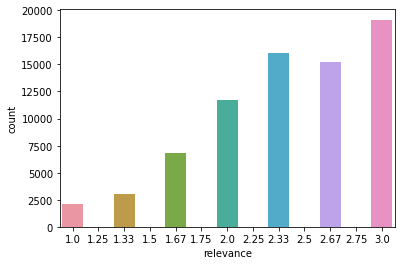

In [29]:
ax = sns.countplot(x="relevance", data=df)

In [30]:
len(pd.unique(df['relevance']))

13

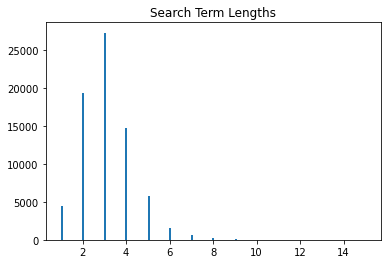

In [31]:
search_term_lengths = df['search_term_tokens'].map(len).tolist()
_ = plt.hist(search_term_lengths, bins='auto')  # arguments are passed to np.histogram
plt.title("Search Term Lengths")
plt.show()

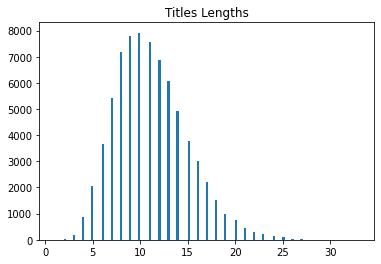

In [32]:
title_lengths = df['product_title_tokens'].map(len).tolist()
_ = plt.hist(title_lengths, bins='auto') 
plt.title("Titles Lengths")
plt.show()

In [33]:
MAX_SEARCH_TERM_LENGTH = 5
MAX_TITLE_LENGTH = 15

In [34]:
class DatasetLoader(Dataset):

    def __init__(self, df, vocab):
        self._df = df
        self._vocab = vocab

    def __len__(self):
        return len(self._df)

    def _fix_words(self, words_ids, required_size):
        if len(words_ids) > required_size:
            words_ids = words_ids[0: required_size]
        elif len(words_ids) < required_size:
            b = np.zeros(required_size - len(words_ids), dtype=int)
            words_ids = np.concatenate((words_ids, b), axis=None)

        return words_ids

    def __getitem__(self, idx):
        row = self._df.iloc[idx]

        search_term = np.array([self._vocab[w] for w in row['search_term_tokens']])
        search_term_length = min(len(search_term), MAX_SEARCH_TERM_LENGTH)
        search_term = self._fix_words(search_term, MAX_SEARCH_TERM_LENGTH)


        product_title = np.array([self._vocab[w] for w in row['product_title_tokens']])
        product_title_length = min(len(product_title), MAX_TITLE_LENGTH)
        product_title = self._fix_words(product_title, MAX_TITLE_LENGTH)
        
        return row['id'], search_term, search_term_length, product_title, product_title_length, row['relevance']
    


In [35]:
df.sample(1)

,id,product_uid,product_title,search_term,relevance,product_title_tokens,search_term_tokens
23999,73748,120992,American Standard 23.625 in. Slide Bar in Oil ...,"american sandard 1660.225,",2.67,"[american, standard, ##.###, slide, bar, oil, ...","[american, <word>, ####.###]"


In [36]:
BATCH_SIZE = 32

In [37]:
test_df['relevance'] = -1

In [38]:
training_df, validation_df = train_test_split(df, test_size=0.1, random_state=42)
len(training_df)+ len(validation_df), len(df)

(74047, 74047)

In [39]:
EMBEDDING_DIMENSION = 100

titles = df['product_title_tokens'].tolist()
serach_terms = df['search_term_tokens'].tolist()
all_sentenses = list(serach_terms)
all_sentenses.extend(titles)
pad_arr = [PAD_WORD]

all_sentenses = [sentense + pad_arr for sentense   in all_sentenses]
embeddingds_model = Word2Vec(sentences=all_sentenses, vector_size=EMBEDDING_DIMENSION, window=5, min_count=1, workers=4)


In [41]:
vocab = embeddingds_model.wv.key_to_index
len(vocab)

10329

In [69]:
training_df = training_df[['id', 'product_title_tokens', 'search_term_tokens', 'relevance']]
data_loader = DatasetLoader(training_df, vocab)

train_data_loader = torch.utils.data.DataLoader(data_loader,
                                                 batch_size=BATCH_SIZE, shuffle=True, 
                                                 num_workers=4,drop_last=False)


validation_data_df = validation_df[['id', 'product_title_tokens', 'search_term_tokens', 'relevance']]
validation_dataset = DatasetLoader(validation_data_df, vocab)

valiodation_data_loader = torch.utils.data.DataLoader(validation_dataset,
                                                 batch_size=BATCH_SIZE, shuffle=True, 
                                                 num_workers=4,drop_last=False)


test_df_fixed = test_df[(test_df['search_term_tokens'].map(len) > 0) & (test_df['product_title_tokens'].map(len) > 0)]


test_loader = DatasetLoader(test_df_fixed[['id', 'product_title_tokens', 'search_term_tokens', "relevance"]], vocab)

test_data_loader = torch.utils.data.DataLoader(test_loader,
                                                 batch_size=BATCH_SIZE, shuffle=False, 
                                                 num_workers=4,drop_last=False)

len(data_loader), len(test_loader)

(66642, 166659)

In [47]:
class EncoderModel(nn.Module):

    def __init__(self, n_vocab, embedding_dim = 200, lstm_dim_size = 300, output_size = 300, embeddings = None,
                  freeze_embeddingds = True):
        super(EncoderModel, self).__init__()
        self.lstm_dim_size = lstm_dim_size
        self.output_size = output_size
      
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(
              num_embeddings=n_vocab,
              embedding_dim=self.embedding_dim,
          )
        
        self._pretrained = False
        if embeddings is not None:
          self.embeddings.weight = nn.Parameter(embeddings)
          self.embeddings.weight.requires_grad = not freeze_embeddingds
          self._pretrained = True

        self.rnn = nn.LSTM(self.embedding_dim, self.lstm_dim_size, 1, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(self.lstm_dim_size * 2, self.output_size)
        self.d1 = nn.Dropout(p=0.4)
        


   
    def forward(self, x, lengths):

        embed = self.embeddings(x)
            
        packed_input = pack_padded_sequence(embed, lengths, batch_first=True, enforce_sorted=False)
        
        packed_output, hn = self.rnn(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        
        out_forward = output[range(len(output)), lengths - 1, :self.embedding_dim ]
        out_reverse = output[:, 0, self.embedding_dim :]
        out = torch.cat((out_forward, out_reverse), 1)
        out = self.d1(out)
        out = self.fc1(out)
        out = torch.tanh(out)

        return out
    
    def reset_parameters(self):
        nn.init.uniform_(self.fc1.weight)
        nn.init.uniform_(self.fc1.bias)

        if not self._pretrained:
          nn.init.uniform_(self.embeddings.weight, -1.0, 1.0)
        

        for name, param in self.rnn.named_parameters():
            if 'weight_ih' in name:
                torch.nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                torch.nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
        

class RelevanceModel(nn.Module):

  def __init__(self, n_vocab, embedding_dim = 200, lstm_dim_size = 300, encoder_output_size = 300,
               embeddings = None, freeze_embeddingds = True):
    
    super(RelevanceModel, self).__init__()
    self.encoder = EncoderModel(n_vocab, embedding_dim, lstm_dim_size, encoder_output_size, embeddings = embeddings,
                                freeze_embeddingds = freeze_embeddingds)
    self.encoder_output_size = encoder_output_size

    self.fc = nn.Linear(self.encoder_output_size * 2, 1)
    self.d1 = nn.Dropout(p=0.4)


  def  forward(self, queries, titles, queries_lengths, titles_lengths):
    
    encoded_queries = self.encoder(queries, queries_lengths)
    title_encoded = self.encoder(titles, titles_lengths)
    
    out = torch.cat((encoded_queries, title_encoded), 1)  
    out = self.d1(out)

    out = self.fc(out)
    
    return out 


  def reset_parameters(self):
    nn.init.uniform_(self.fc.weight)
    nn.init.uniform_(self.fc.bias)
    self.encoder.reset_parameters()

  

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [45]:
df.sample(1)

,id,product_uid,product_title,search_term,relevance,product_title_tokens,search_term_tokens
70190,210329,197233,Home Decorators Collection Winchester Evergold...,rugs allen roth,2.33,"[home, decor, collect, winchest, <word>, #, ft...","[rug, allen, roth]"


In [63]:
#model1
learnniong_rate = 0.0001

model = RelevanceModel(len(vocab), EMBEDDING_DIMENSION, 200, 200, 
                       embeddings = torch.FloatTensor(embeddingds_model.wv.vectors))
model.reset_parameters()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learnniong_rate)

criterion = torch.nn.MSELoss().to(device)


In [64]:
#model 2
learnniong_rate = 0.0001

model = RelevanceModel(len(vocab), EMBEDDING_DIMENSION, 200, 200,
                       embeddings = torch.FloatTensor(embeddingds_model.wv.vectors),
                       freeze_embeddingds = False)

model.reset_parameters()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learnniong_rate)


criterion = torch.nn.MSELoss().to(device)

In [60]:
#model 3
learnniong_rate = 0.0001

model = RelevanceModel(len(vocab), EMBEDDING_DIMENSION, 200, 200,
                       embeddings = None)

model.reset_parameters()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learnniong_rate)

criterion = torch.nn.MSELoss().to(device)

In [65]:
def train_epoc(epoc):

  model.train()
  running_loss = 0.0
  counter = 0.0

  for ids, search_term, search_term_length, product_title, product_title_length, target_relevance_score in train_data_loader:
    search_term = Variable(search_term).to(device)
    product_title = Variable(product_title).to(device)
    target_relevance_score = Variable(target_relevance_score).float().to(device)

    optimizer.zero_grad()

    scores = model(search_term, product_title, search_term_length,  product_title_length)
    loss = criterion(scores, target_relevance_score)

      

    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    counter += search_term.shape[0]
    

  return running_loss/counter



def validation():
  model.eval()

  running_loss  = 0.0
  counter = 0.0

  with torch.no_grad():
    for ids, search_term, search_term_length, product_title, product_title_length, target_relevance_score in valiodation_data_loader:
      search_term = Variable(search_term).to(device)
      product_title = Variable(product_title).to(device)
      target_relevance_score = Variable(target_relevance_score).float().to(device)
      scores = model(search_term, product_title, search_term_length,  product_title_length)

    
      
      loss = criterion(scores, target_relevance_score)
      running_loss += loss.item()
      counter += search_term.shape[0]
  
  return running_loss/counter


  


In [66]:
liveloss = PlotLosses()

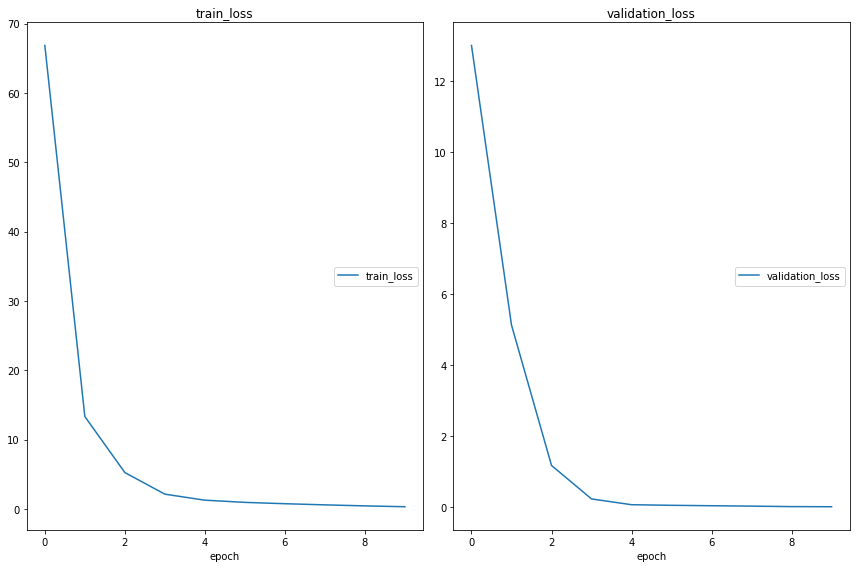

train_loss
	train_loss       	 (min:    0.322, max:   66.843, cur:    0.322)
validation_loss
	validation_loss  	 (min:    0.011, max:   13.007, cur:    0.011)


KeyboardInterrupt: ignored

In [67]:
for epoc in range(10000):

  train_loss = train_epoc(epoc)
  validation_loss = validation()

  liveloss.update({
          'train_loss': train_loss,
          'validation_loss': validation_loss
      })
    
  liveloss.draw()


In [70]:
model.eval()
test_scores = []
test_ids =[]
tt = []
test_data = []
with torch.no_grad():
  for ids, search_term, search_term_length, product_title, product_title_length, target_relevance_score in test_data_loader:
     
    search_term = Variable(search_term).to(device)
    product_title = Variable(product_title).to(device)
    

    scores = model(search_term, product_title, search_term_length,  product_title_length)

    predictions = scores.flatten().detach().cpu().numpy().tolist()
    ids = ids.numpy().tolist()

    test_data.extend(zip(ids, predictions))



    
  

In [72]:

all_ids = {x for (x, _) in test_data}

for _, row in test_df.iterrows():
  if row['id'] not in all_ids:
    test_data.append((row['id'], 1))
    
len(test_data), len(test_df)

(166693, 166693)

In [85]:
test_res_df = pd.DataFrame([(id, max(1.0, min(score, 3.0))) for (id, score) in test_data], columns = ["id", "relevance"])
test_res_df.to_csv("test_res.csv", index=  False)


In [86]:
test_res_df.sample(10)

,id,relevance
99930,149047,2.511062
84913,126463,2.364512
19633,28984,2.821791
108112,161275,2.324393
81011,120541,2.459251
106813,159270,2.643362
153736,227832,2.474241
5090,7551,2.664682
71299,105965,2.287331
165159,239259,2.451044


In [88]:
from google.colab import files
files.download('test_res.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_df.sample(1)

,id,product_uid,product_title,search_term,product_title_tokens,search_term_tokens,my_relevance
107023,159578,161578,Speedi-Products 7 in. 24-Gauge Single Wall Stove Pipe 90 Degree Adjustable Elbow in Black Matte,singel wall stove pipe,"[speedi, product, #, ##, gaug, singl, wall, stove, pipe, ##, degre, adjust, elbow, black, matt]","[singel, wall, stove, pipe]",1
